# Underfitting & Overfitting in Decision Trees and Random Forests


In this notebook we will use  the famous Adult dataset, retrieved from the UCI Machine Learning Repository. This is a dataset for a binary classification task, where the task is to predict whether an American individual earns more than $50,000 a year, given a number of numerical and categorical features.

First, we will focus on overfitting using decision trees and RF.

Second, I will build a complete model using repeated stratified k-fold cross-validation to evaluate the model. For this, I will introduce Pipeline.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels as sms

In [2]:
#We have 2 datasets, one for the training and one for the test

df_train = pd.read_csv('data/adult_train.csv')
df_test = pd.read_csv('data/adult_test.csv')

In [3]:
df_test.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


Each entry contains the following information about the class of individual:

    age: the age of an individual

    workclass: a general term to represent the employment status of an individual

    fnlwgt: final weight. In other words, this is the number of people the census believes the entry represents.

    education: the highest level of education achieved by an individual.

    education-num: the highest level of education achieved in numerical form.

    marital-status: marital status of an individual. Note: Married-civ-spouse corresponds to a civilian spouse while Married-AF-spouse is a spouse in the Armed Forces.

    occupation: the general type of occupation of an individual

    relationship: represents what this individual is relative to others. For example an individual could be a Husband. Each entry only has one relationship attribute and is somewhat redundant with marital status.

    race: Descriptions of an individual’s race

    sex: the biological sex of the individual

    capital-gain: capital gains for an individual (money gained outside of salary)

    capital-loss: capital loss for an individual (money lost outside of salary)

    hours-per-week: the hours an individual has reported to work per week

    native-country: country of origin for an individual

    income: whether or not an individual makes more than 50,000 annually.


In [4]:
df_train.shape,df_test.shape

((32561, 15), (16281, 15))

Both dataset have the same number of columns, but of course the training sample has half the training sample size

In [5]:
# I create a concatenate dataframe, so it is easier to check for missing values in both, apply feature engineering 
df_tot = pd.concat([df_train, df_test], ignore_index=True)

In [6]:
# running .str.strip() on all string objects
# a lot have space
df_obj = df_tot.select_dtypes(['object'])
df_tot[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

In [7]:
# checking datatypes
df_tot.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB



    The dataset contains absolutely no null values!
    
    Age, Final Weight, Education Number, Capital Gain, Capital Loss and Hours Per Week are integer columns.
    There are no Float Datatypes in the dataset.
    
    Workclass, Education, Marital Status, Occupation, Relationship, Race, Sec, Native Country and Income are of object datatypes.
    
    Although the dataset does not contain any null values, we need to check for "?" values


In [8]:
df_tot.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


The minimum and maximum age of people in the dataset is 17 and 90 years respectively, while the average age is 38.6.

The minimum and maximum years spent on education is 1 and 16 respectively, whereas the mean education level is 10 years.

While the minimum and average capital gain is 0, maximum is 99999. This seems odd, maybe some error within the data collection.

The number of hours spent per week varies between 1 to 99 and the average being 40 hours, again 99 does not look good

In [9]:
df_tot.replace('?', np.nan, inplace=True)
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Note, that both workclass and occupation have a large number of '?' rows. Workclass and occupation are closely co-correlated - so if it's an unknown workclass, then it must be an unknown occupation as well. Also the numbers are very similar but not exact.

In [10]:
# checking to see if the unknown rows line up:

'Workclass feature:'
print(df_tot[df_tot['workclass'].isna()].index)

'Occupation feature'
print(df_tot[df_tot['occupation'].isna()].index)


Index([   27,    61,    69,    77,   106,   128,   149,   154,   160,   187,
       ...
       48567, 48579, 48593, 48596, 48678, 48682, 48769, 48800, 48812, 48838],
      dtype='int64', length=2799)
Index([   27,    61,    69,    77,   106,   128,   149,   154,   160,   187,
       ...
       48567, 48579, 48593, 48596, 48678, 48682, 48769, 48800, 48812, 48838],
      dtype='int64', length=2809)


In [11]:
# which rows are there that these don't line up?

unknown_occ = df_tot[df_tot['occupation'].isna()]

unknown_occ[~unknown_occ.workclass.isna()]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
5361,18,Never-worked,206359,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
10845,23,Never-worked,188535,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,35,United-States,<=50K
14772,17,Never-worked,237272,10th,6,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,<=50K
20337,18,Never-worked,157131,11th,7,Never-married,NaN,Own-child,White,Female,0,0,10,United-States,<=50K
23232,20,Never-worked,462294,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,<=50K
32304,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,NaN,Wife,Black,Female,0,0,40,United-States,<=50K
32314,18,Never-worked,153663,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,4,United-States,<=50K
41346,17,Never-worked,131593,11th,7,Never-married,NaN,Own-child,Black,Female,0,0,20,United-States,<=50K.
44168,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,NaN,Other-relative,White,Male,0,0,35,United-States,<=50K.
46459,18,Never-worked,162908,11th,7,Never-married,NaN,Own-child,White,Male,0,0,35,United-States,<=50K.




Looks like the "Never-worked" category can be turned into '?' for simplicity's sake. This doesn't seem like something that adds any value.


In [12]:
df_tot.loc[df_tot['workclass'] == 'Never-worked', 'workclass'] = np.nan

In [13]:
# are there any other missing / null values?
df_tot.isnull().sum()

age                   0
workclass          2809
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

Now workclass and occupation have the same number of NaN

In [14]:
# checking out our target income class:
df_tot.income.value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [15]:
# cleaning this up and removing the period from those stray values so our values line up better
df_tot.loc[df_tot.income == '<=50K.', 'income'] = '<=50K'
df_tot.loc[df_tot.income == '>50K.', 'income'] = '>50K'

# Data Visualization

In [16]:
import seaborn as sns

plt.rcParams['legend.numpoints']=1
plt.rcParams['xtick.major.size'] = 21
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 21
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.visible']=True #See minor tick
plt.rcParams['text.usetex']=False #use Latex
plt.rcParams['axes.linewidth']=2 #width axes
plt.rcParams['axes.labelsize']=20 #
plt.rcParams['ytick.labelsize']=16 #fontsize of tick labels
plt.rcParams['xtick.labelsize']=16 #fontsize of tick labels
plt.rcParams['ytick.direction']='inout' ## direction: in, out, or inout
plt.rcParams['xtick.direction']='inout' ## direction: in, out, or inout

plt.rcParams['xtick.major.top']=True #draw x axis top major ticks
plt.rcParams['xtick.major.bottom']=True #draw x axis bottom major ticks
plt.rcParams['xtick.minor.top']=True ## draw x axis top minor ticks
plt.rcParams['xtick.minor.bottom']=True #draw x axis bottom minor ticks

plt.rcParams['ytick.major.left']=True #draw y axis left major ticks
plt.rcParams['ytick.major.right']=True #draw y axis right major ticks
plt.rcParams['ytick.minor.left']=True ## draw y axis left minor ticks
plt.rcParams['ytick.minor.right']=True #draw y axis right minor ticks
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight'] = 'heavy'

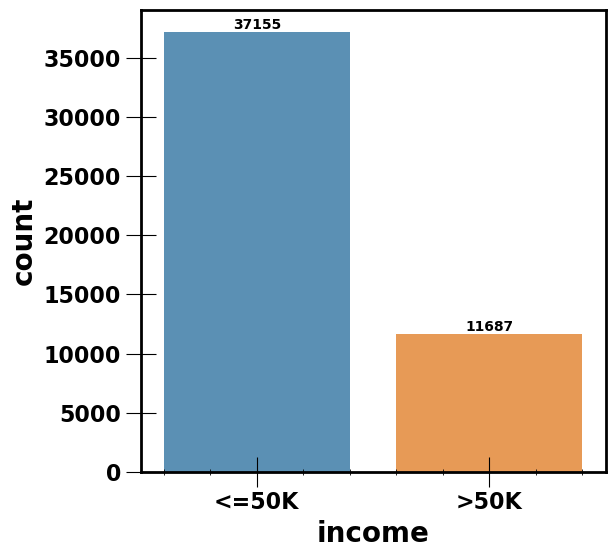

In [17]:
plt.figure(figsize=(6,6))
ax=sns.countplot(x='income', hue="income", data=df_tot,alpha=0.8)

for container in ax.containers:
    ax.bar_label(container)


The number of people earning more than 50K dollars an year is one third of the people earning less than it.

In [18]:
def age_group(x):
    x = int(x)
    x = abs(x)
    if( 18 < x < 31 ):
        return "19-30"
    if( 30 < x < 41 ):
        return "31-40"
    if( 40 < x < 51 ):
        return "41-50"
    if( 50 < x < 61 ):
        return "51-60"
    if( 60 < x < 71 ):
        return "61-70"
    else:
        return "> 70"

df_tot['age_group'] = df_tot['age'].apply(age_group)

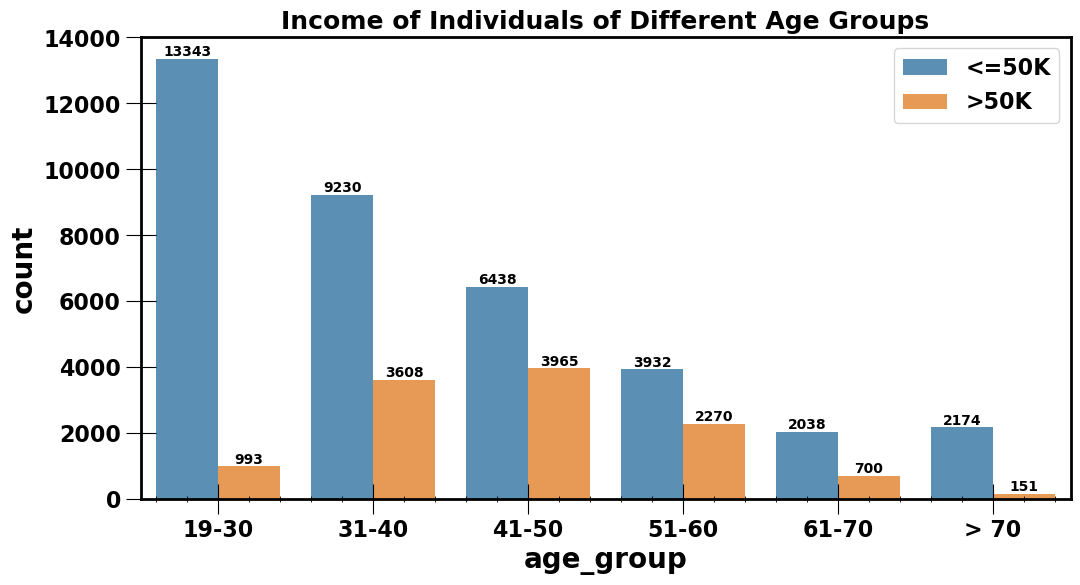

In [19]:


plt.figure(figsize=(12,6))
order_list = ['19-30', '31-40', '41-50', '51-60', '61-70', '> 70']
ax=sns.countplot(x='age_group', hue = 'income',data=df_tot, order = order_list,alpha=0.8)
plt.title('Income of Individuals of Different Age Groups', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# Add bar labels
for container in ax.containers:
    ax.bar_label(container)

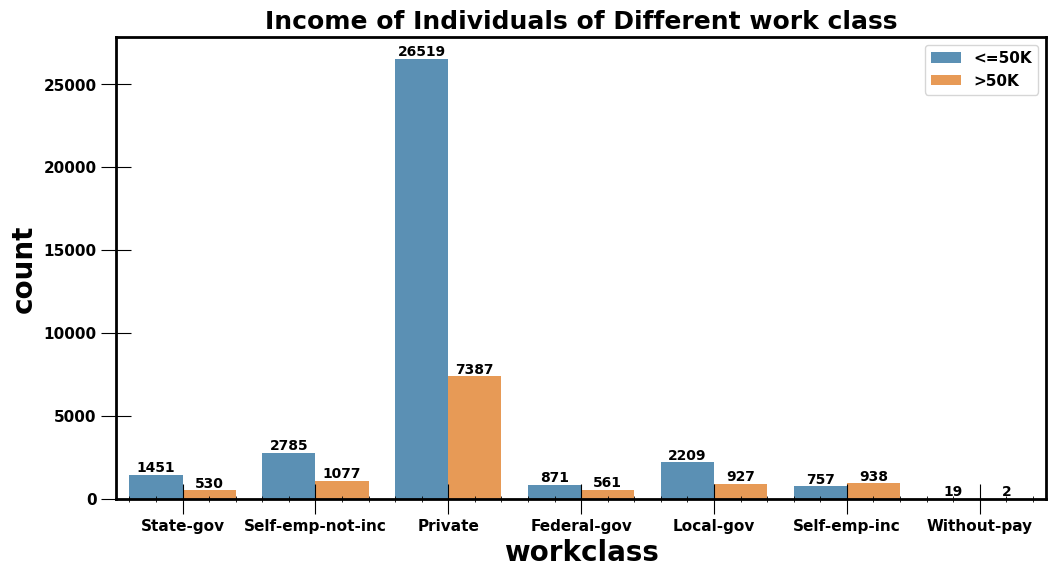

In [20]:
plt.figure(figsize=(12,6))
ax=sns.countplot(x='workclass', hue = 'income',data=df_tot,alpha=0.8)
plt.title('Income of Individuals of Different work class', fontsize=18, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
# Add bar labels
for container in ax.containers:
    ax.bar_label(container)


It is quite interesting to see that Self-Employed is the only category where the number of people who earn more than 50K dollars exceed those earning less than it! It might be conducive to suggest that when you handle your own business, start-up, etc. you are more likely to earn better if it gets successful!

People working in the Private Sector face a significant difference between their pays where more than 75% of them earn less than 50K dollars an year!

There is a very minute difference between the number of people whose income is more or less than 50K dollars an year who work for the Federal Govt.


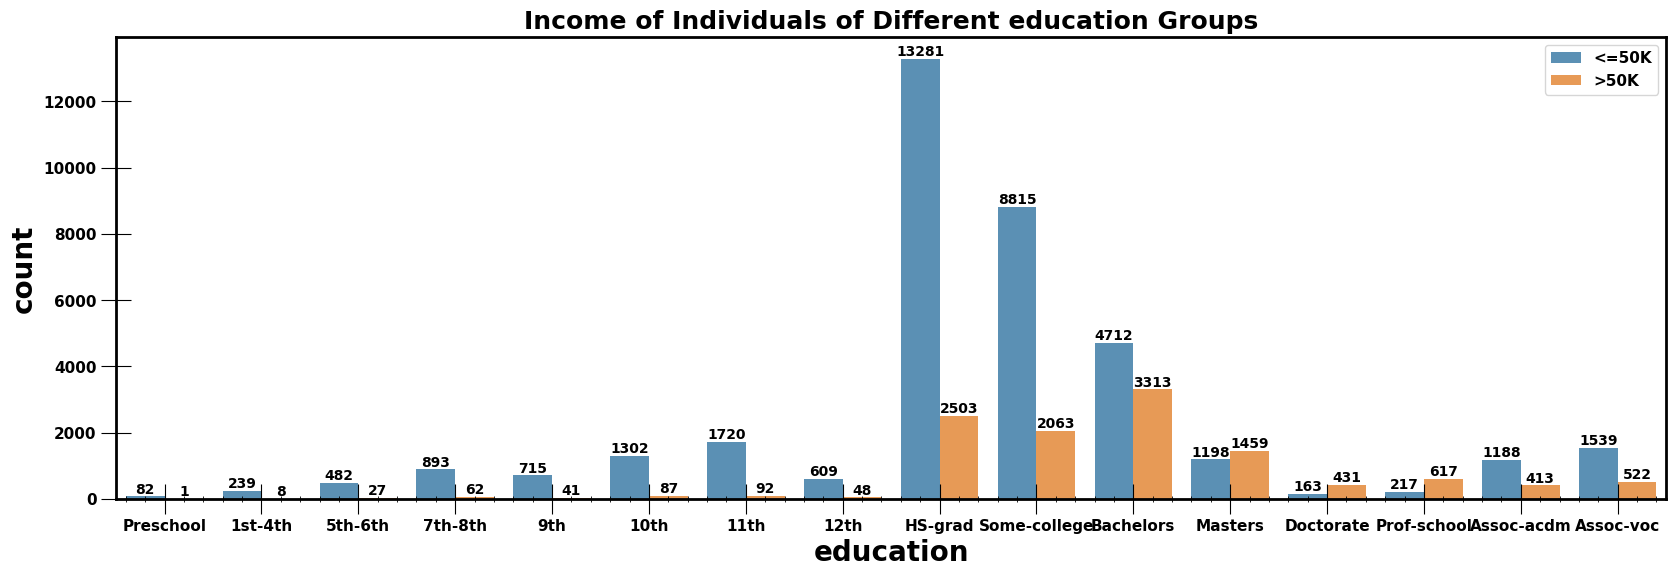

In [21]:
plt.figure(figsize=(20,6))
order_list = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 
                'HS-grad', 'Some-college', 'Bachelors', 'Masters', 'Doctorate', 'Prof-school', 
              'Assoc-acdm', 'Assoc-voc']
ax=sns.countplot(x='education', hue = 'income',data=df_tot, order = order_list,alpha=0.8)
plt.title('Income of Individuals of Different education Groups', fontsize=18, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
# Add bar labels
for container in ax.containers:
    ax.bar_label(container)

In [22]:
df_tot['education'].replace('Preschool', 'dropout',inplace=True)
df_tot['education'].replace('10th', 'dropout',inplace=True)
df_tot['education'].replace('11th', 'dropout',inplace=True)
df_tot['education'].replace('12th', 'dropout',inplace=True)
df_tot['education'].replace('1st-4th', 'dropout',inplace=True)
df_tot['education'].replace('5th-6th', 'dropout',inplace=True)
df_tot['education'].replace('7th-8th', 'dropout',inplace=True)
df_tot['education'].replace('9th', 'dropout',inplace=True)
df_tot['education'].replace('Some-college', 'CommunityCollege',inplace=True)
df_tot['education'].replace('Assoc-acdm', 'CommunityCollege',inplace=True)
df_tot['education'].replace('Assoc-voc', 'CommunityCollege',inplace=True)
np.unique(df_tot.education)



array(['Bachelors', 'CommunityCollege', 'Doctorate', 'HS-grad', 'Masters',
       'Prof-school', 'dropout'], dtype=object)

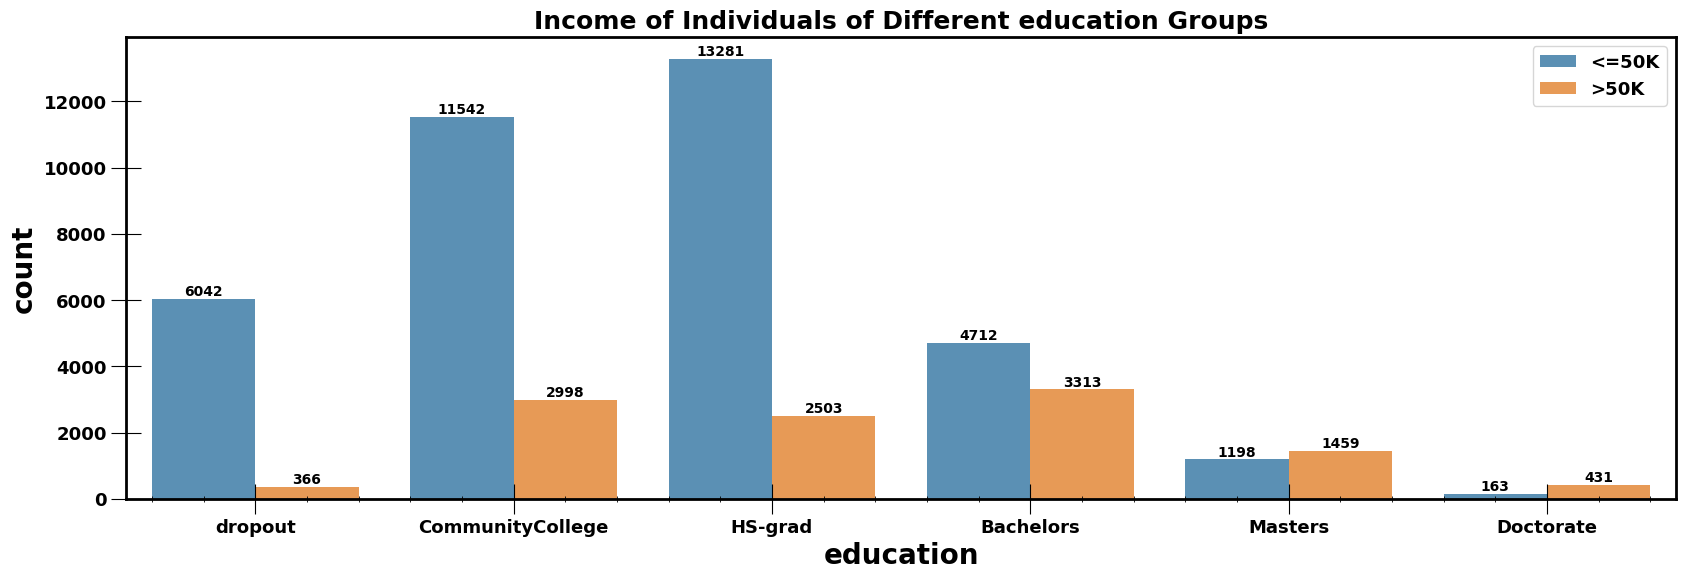

In [23]:
plt.figure(figsize=(20,6))
order_list = ['dropout', 'CommunityCollege', 'HS-grad', 'Bachelors', 'Masters', 'Doctorate']
ax=sns.countplot(x='education', hue = 'income',data=df_tot, order = order_list,alpha=0.8)
plt.title('Income of Individuals of Different education Groups', fontsize=18, fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
# Add bar labels
for container in ax.containers:
    ax.bar_label(container)

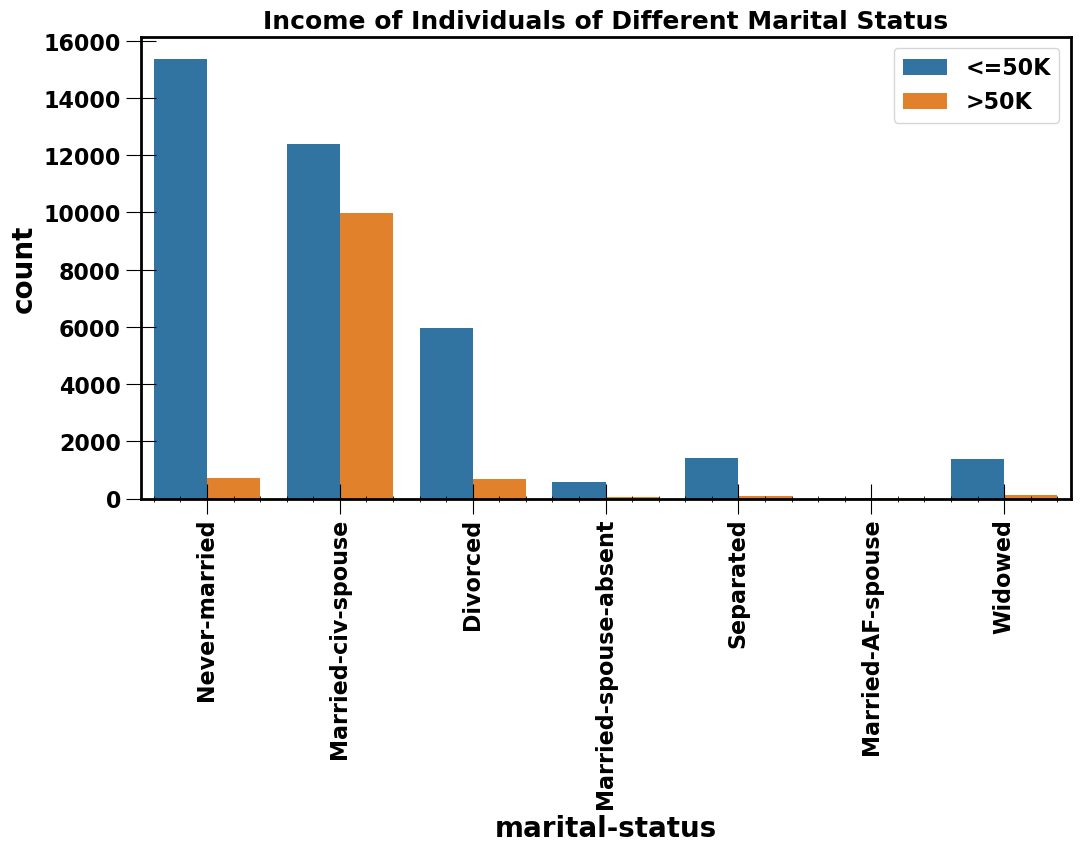

In [24]:
plt.figure(figsize=(12,6))
#order_list = ['19-30', '31-40', '41-50', '51-60', '61-70', 'Greater than 70']
sns.countplot(x='marital-status',data=df_tot, hue = 'income')
plt.title('Income of Individuals of Different Marital Status', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16,rotation = 90)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# Add bar labels
for container in ax.containers:
    ax.bar_label(container)

# Data Preparation: Feature Engineering

In [25]:
df_ml=df_tot.copy()
df_ml


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,age_group
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,31-40
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,41-50
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,31-40
3,53,Private,234721,dropout,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,51-60
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,19-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K,31-40
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K,61-70
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K,31-40
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K,41-50


In this dataset, there are several features with categorical values, such as workclass, education etc. All scikit-learn models work with numerical data internally; this means that the categorical features need to be converted to numbers. The most straightforward way to carry out such a conversion is to use one-hot encoding of the features, also known as dummy variables in statistics. In this approach, you define one new column for each observed value of the feature.

In [26]:
 # split into inputs and outputs
 X, y = df_ml.drop(['age_group','income'],axis=1), df_ml['income']

In [27]:
cat_ix = X.select_dtypes(include=['object', 'bool']).columns
num_ix = X.select_dtypes(include=['int64', 'float64']).columns
cat_ix

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')

In [28]:
from sklearn.preprocessing import LabelEncoder
# label encode the target variable to have the classes 0 and 1
y = LabelEncoder().fit_transform(y)
print(y)

[0 0 0 ... 0 0 1]


In [30]:
from sklearn.preprocessing import OneHotEncoder

#We will one-hot encode the categorical input variables using a OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the data
encoded_features = encoder.fit_transform(X[cat_ix])
encoded_feature_names = encoder.get_feature_names_out(cat_ix)
np.size(encoded_feature_names)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
# Combine the encoded features with the original DataFrame
X = pd.concat([X.drop(columns=cat_ix), encoded_df], axis=1)
X

#You can also use pandas: X = pd.get_dummies(X columns=cat_ix, drop_first=False)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_nan
0,39,77516,13,2174,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,50,83311,13,0,0,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,38,215646,9,0,0,40,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,53,234721,7,0,0,40,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,28,338409,13,0,0,40,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,215419,13,0,0,36,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48838,64,321403,9,0,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48839,38,374983,13,0,0,50,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48840,44,83891,13,5455,0,40,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
# we will normalize the numerical input variables using the MinMaxScaler.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_norm = pd.DataFrame(scaler.fit_transform(X[num_ix]), columns = num_ix)
# Combine the encoded features with the original DataFrame
X = pd.concat([x_norm,X.drop(columns=num_ix)], axis=1)
X

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_nan
0,0.301370,0.044131,0.800000,0.021740,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.452055,0.048052,0.800000,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.287671,0.137581,0.533333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.493151,0.150486,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.150685,0.220635,0.800000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.301370,0.137428,0.800000,0.000000,0.0,0.357143,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48838,0.643836,0.209130,0.533333,0.000000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48839,0.287671,0.245379,0.800000,0.000000,0.0,0.500000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48840,0.369863,0.048444,0.800000,0.054551,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Decision trees

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [33]:
dt_train_accuracy_list = []
dt_test_accuracy_list = []
for depth in range(1,21):
    dtclf = DecisionTreeClassifier(max_depth=depth)
    dtclf.fit(X_train, y_train)
    y_pred_train = dtclf.predict(X_train)
    dt_train_accuracy_list.append(accuracy_score(y_train, y_pred_train))
    y_pred_test = dtclf.predict(X_test)
    dt_test_accuracy_list.append(accuracy_score(y_test, y_pred_test))

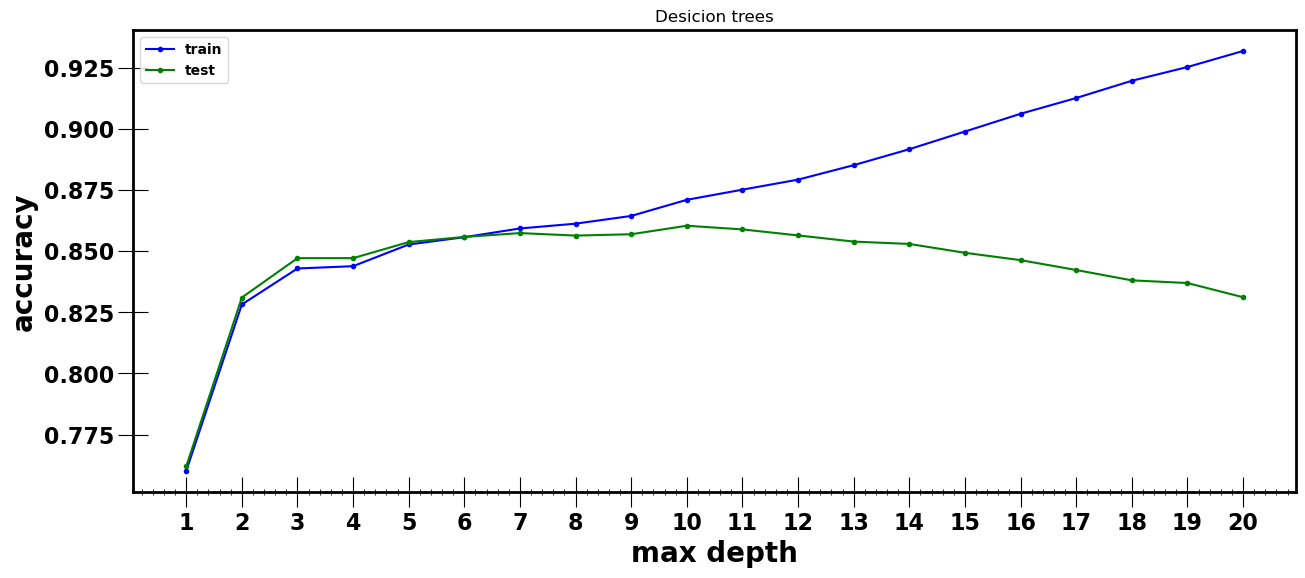

In [34]:
plt.figure(figsize=(15,6))

plt.plot(range(1,21), dt_train_accuracy_list, c='blue', label='train', marker='.')
plt.plot(range(1,21), dt_test_accuracy_list, c='green', label='test', marker='.')
plt.xticks(range(1,21))
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Desicion trees')
plt.legend()
plt.show()

The plot shows that the accuracy for the training data continues to increase while the accuracy for the test data begins to decrease when the max depth exceeds 10. This indicates that the DecisionTreeClassifier is overfitting, memorizing the specific details of the training data at max depths greater than 10

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
dt_train_accuracy_list = []
dt_test_accuracy_list = []
for depth in range(1,21):
    dtclf = RandomForestClassifier(max_depth=depth)
    dtclf.fit(X_train, y_train)
    y_pred_train = dtclf.predict(X_train)
    dt_train_accuracy_list.append(accuracy_score(y_train, y_pred_train))
    y_pred_test = dtclf.predict(X_test)
    dt_test_accuracy_list.append(accuracy_score(y_test, y_pred_test))

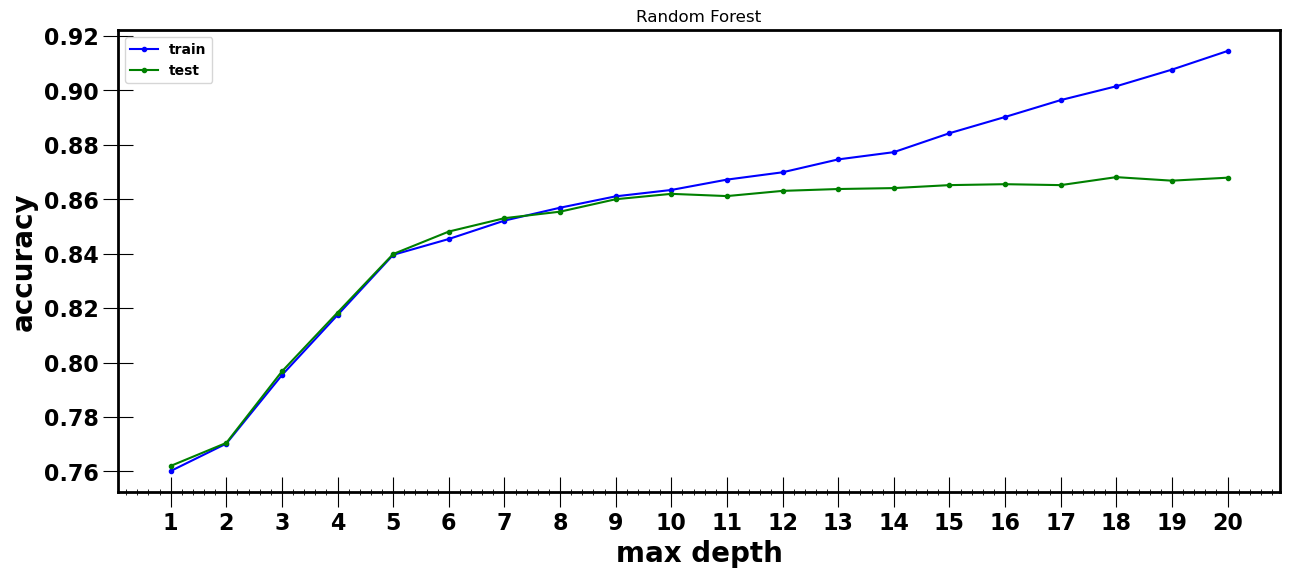

In [36]:
plt.figure(figsize=(15,6))

plt.plot(range(1,21), dt_train_accuracy_list, c='blue', label='train', marker='.')
plt.plot(range(1,21), dt_test_accuracy_list, c='green', label='test', marker='.')
plt.xticks(range(1,21))
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Random Forest')
plt.legend()
plt.show()

It can be observed that the test accuracy of the random forest classifier with an ensemble size of 100 does not decrease as the max depth increases; instead, it remains stable. In contrast, the test accuracy of the decision tree classifier decreases due to overfitting the training data. This stability in the random forest model occurs because its variance is significantly reduced compared to a single decision tree. By creating many decision trees with added randomness and then averaging their predictions, the random forest prevents overfitting. This demonstrates why random forests are more robust than single decision trees.

#### Fine tuned Random forest model

In [37]:
from sklearn.model_selection import GridSearchCV

max_dept_list = [9, 10, 11]
n_estimators_list = [50,100,200]

params = {}
params['max_depth'] = max_dept_list
params['n_estimators'] = n_estimators_list

grid = GridSearchCV(RandomForestClassifier(random_state=0), params, cv=4, scoring='accuracy', n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [9, 10, 11],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [38]:
grid.best_params_

{'max_depth': 11, 'n_estimators': 200}

In [39]:
print('Accuracy train sample: %0.3f'%grid.best_score_)

Accuracy train sample: 0.858


In [40]:
rfclf_final = RandomForestClassifier(random_state=0, max_depth = 11, n_estimators=200)
rfclf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, n_estimators=200, random_state=0)

In [41]:
y_pred_test = rfclf_final.predict(X_test)
print('Accuracy test sample: %0.3f'%accuracy_score(y_test, y_pred_test))

Accuracy test sample: 0.861


**Check importance features**

In [42]:
rf_feature_scores = rfclf_final.feature_importances_
feature_names=X.columns
for score, fname in sorted(zip(rf_feature_scores, feature_names), reverse=True)[:10]:
    print(fname, score)

capital-gain 0.15965306590374662
marital-status_Married-civ-spouse 0.14547649476143523
educational-num 0.09896356010334269
relationship_Husband 0.08725124937494096
age 0.06236027362814141
marital-status_Never-married 0.054107284384434136
capital-loss 0.03939984127698244
hours-per-week 0.03929407101489648
occupation_Exec-managerial 0.026358251367611784
relationship_Not-in-family 0.0240983935511102


# Comparaison different models using Pipeline

In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [51]:
# define models to test
def get_models():
 models, names = list(), list()
 # CART
 models.append(DecisionTreeClassifier())
 names.append('CART')
 # SVM
 models.append(SVC(gamma='scale'))
 names.append('SVM')
 # Bagging
 models.append(BaggingClassifier(n_estimators=100))
 names.append('BAG')
 # RF
 models.append(RandomForestClassifier(n_estimators=100))
 names.append('RF')
 # GBM
 models.append(GradientBoostingClassifier(n_estimators=100))
 names.append('GBM')
  # ADABoost Classifier with decision trees
 models.append(AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=200,learning_rate=0.5, random_state=42))
 names.append('ADAboost+CART')   
 return models, names

In [52]:
'''
We will evaluate candidate models using repeated stratified k-fold cross-validation.

The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, 
at least compared to a single train-test split. 

Stratified means that each fold will contain the same mixture of examples by class, that is about 75 percent to 25 percent 
for the majority and minority classes respectively. 

Repeated means that the evaluation process will be performed multiple times to help avoid fluke results
and better capture the variance of the chosen model. We will use one repeats.

We use only 5 n_splits and 1 n_repeats for computing time but it is better to do 10 and 3 (30 in total for each model)

'''
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [53]:
X, y = df_ml.drop(['age_group','income'],axis=1), df_ml['income']
cat_ix = X.select_dtypes(include=['object', 'bool']).columns
num_ix = X.select_dtypes(include=['int64', 'float64']).columns
# define models
models, names = get_models()

# I will also add a voting classifier
voting_models = [(names[i], models[i]) for i in range(len(models))]
voting_classifier = VotingClassifier(estimators=voting_models, voting='hard')

# Append VotingClassifier to models and names
models.append(voting_classifier)
names.append('Voting')


results = list()
# evaluate each model
for i in range(len(models)):
 # define steps
 steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
 # one hot encode categorical, normalize numerical
 ct = ColumnTransformer(steps)
 # wrap the model i a pipeline
 pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
 # evaluate the model and store results
 scores = evaluate_model(X, y, pipeline)
 results.append(scores)
 # summarize performance
 print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))


>CART 0.817 (0.002)
>SVM 0.841 (0.002)
>BAG 0.858 (0.001)
>RF 0.855 (0.003)
>GBM 0.868 (0.004)


/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

>ADAboost+CART 0.861 (0.005)


/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/tdejaege/anaconda3/envs/lemaitre/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

>Voting 0.867 (0.002)


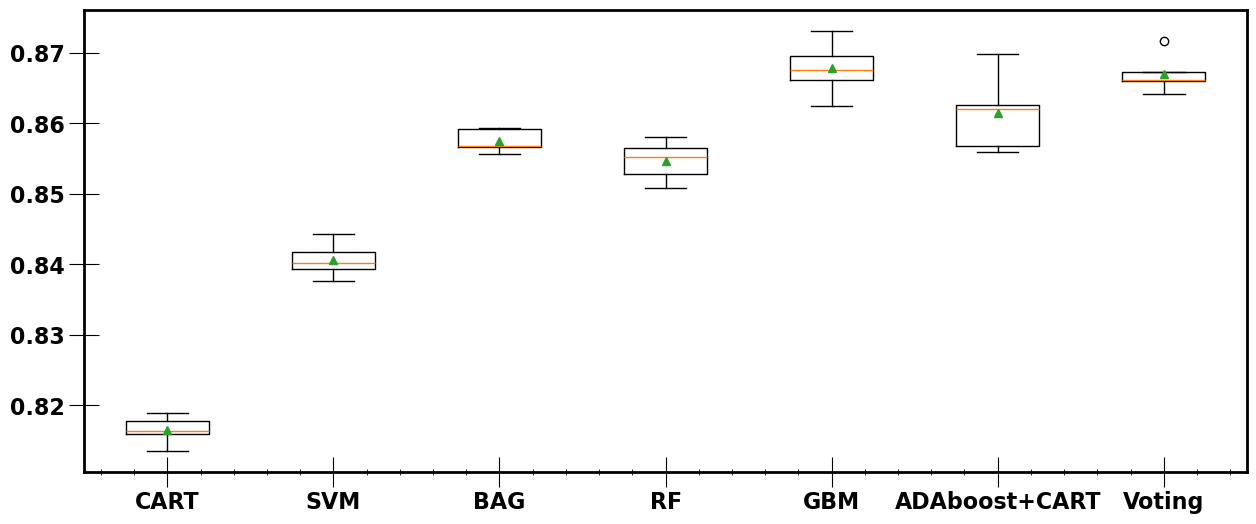

In [54]:
# plot the results
plt.figure(figsize=(15,6))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()